# TOPIC MODELLING TECHNIQUES

## USE OF DATASETS WITH GROUND TRUTH FOR COMPARING TOPIC MODELLING TECHNIQUES

We are going to compare topic/keyword extraction of LLM with LDA

In [1]:
import os
import pandas as pd

# Define the folder path containing the dataset
folder_path = 'C://1. Python//LLM_mods_Topic_Modelling//hulth2003_train'

# Lists to store extracted data
document_ids = []
abstracts = []
controlled_keywords = []
uncontrolled_keywords = []

# Loop through the folder and process files
for file_name in os.listdir(folder_path):
    if file_name.endswith('.abstr'):
        # Get the document ID (e.g., '6' from '6.abstr')
        doc_id = file_name.split('.')[0]
        
        # Read the abstract
        with open(os.path.join(folder_path, f'{doc_id}.abstr'), 'r') as f:
            abstract = f.read().strip()
        
        # Read the controlled keywords
        with open(os.path.join(folder_path, f'{doc_id}.contr'), 'r') as f:
            contr_keywords = f.read().strip()
        
        # Read the uncontrolled keywords
        with open(os.path.join(folder_path, f'{doc_id}.uncontr'), 'r') as f:
            uncontr_keywords = f.read().strip()
        
        # Append the extracted data to the lists
        document_ids.append(doc_id)
        abstracts.append(abstract)
        controlled_keywords.append(contr_keywords)
        uncontrolled_keywords.append(uncontr_keywords)

# Create a DataFrame to store the combined data
df = pd.DataFrame({
    'doc_id': document_ids,
    'text': abstracts,
    'controlled_keywords': controlled_keywords,
    'original_keywords': uncontrolled_keywords
})

# Display the first few rows of the DataFrame
df.head()

,doc_id,text,controlled_keywords,original_keywords
0,100,Separate accounts go mainstream [investment]\n...,investment,separate-account industry; Web-based platforms...
1,1000,Does classicism explain universality? Argument...,cognitive systems; neural nets; philosophical ...,classicism; universality; classical component ...
2,1001,A conflict between language and atomistic info...,artificial intelligence; cognitive systems; ph...,philosophy of mind; Information-Based Semantic...
3,1002,Selective representing and world-making\nWe di...,artificial intelligence; cognitive systems,world-making; selective representing; mental r...
4,1003,Lob's theorem as a limitation on mechanism\nWe...,belief maintenance; cognitive systems; inferen...,Lob Theorem; limitation on mechanism; epistemi...


In [2]:
# display the data types of each column and search for NaN values
print(df.columns)
print('----------------------------------------------------------------------------------------------------------------------')
print(df.describe())
print('----------------------------------------------------------------------------------------------------------------------')
print(df.isna().sum())
print('----------------------------------------------------------------------------------------------------------------------')
print(f'The total length of the datasets is: {len(df)}')

Index(['doc_id', 'text', 'controlled_keywords', 'original_keywords'], dtype='object')
----------------------------------------------------------------------------------------------------------------------
       doc_id                                               text  \
count    1000                                               1000   
unique   1000                                               1000   
top       100  Separate accounts go mainstream [investment]\n...   
freq        1                                                  1   

       controlled_keywords                                  original_keywords  
count                 1000                                               1000  
unique                 954                                               1000  
top      telecommunication  separate-account industry; Web-based platforms...  
freq                    10                                                  1  
------------------------------------------------------

In [3]:
# take a sample of 1000 comments
df_sample = df[['doc_id', 'text', 'original_keywords']].sample(100)
df_sample = df_sample.reset_index(drop=True)
df_sample.head()

,doc_id,text,original_keywords
0,1413,Web content extraction. A WhizBang! approach\n...,Web content extraction; FlipDog; job descripti...
1,539,Perfusion quantification using Gaussian proces...,perfusion quantification; Gaussian process dec...
2,1213,A knowledge intensive multi-agent framework fo...,knowledge intensive multi-agent framework; col...
3,1233,Advanced optimization strategies in the Rice d...,Mgh-Performance Fortran; legacy Fortran codes;...
4,1394,Subject access to government documents in an e...,government documents; globalization; intellect...


### CREATE A KEYWORD EXTRACTION WITH LDA (LATENT DIRICHLET ALLOCATION)

In [4]:
from topic_modelling_techniques.lda_keyword_extraction import extract_keywords_for_all_comments

text_col='text'

# Find the optimal number of keywords per comment, implement LDA and 
df_sample = extract_keywords_for_all_comments(df_sample, text_col, min_topics=1, max_topics=10, find_optimal=(True, None))

# View the result
df_sample[['text', 'lda_keywords', 'optimal_num_topics']]

,text,lda_keywords,optimal_num_topics
0,Web content extraction. A WhizBang! approach\n...,[job],1
1,Perfusion quantification using Gaussian proces...,[gpd],1
2,A knowledge intensive multi-agent framework fo...,[design],1
3,Advanced optimization strategies in the Rice d...,[optimization],1
4,Subject access to government documents in an e...,[supranational],1
...,...,...,...
95,"A round of cash, a pound of flesh [telecom]\nD...",[ups],1
96,The impact and implementation of XML on busine...,[business],1
97,Modelling of complete robot dynamics based on ...,[neural],1
98,A model for choosing an electronic reserves sy...,[reserves],1


### CALCULATE THE COSINE SIMILARITY BETWEEN LDA KEYWORDS AND ORIGINAL KEYWORDS

#### FIRSTLY CALCULATE THE EMBEDDINGS OF THE KEYWORDS

In [9]:
from sklearn.preprocessing import MultiLabelBinarizer
from utils.text_to_embeddings import calc_embeddings
from sklearn.decomposition import PCA

# modify the topics in order to be able to tokenize them in a transformer
df_sample['original_keywords_str'] = df_sample['original_keywords'].apply(lambda x: x.replace(';', " "))
df_sample['original_keywords_str'] = df_sample['original_keywords'].apply(lambda x: x.replace('\n', " "))
df_sample['original_keywords_str'] = df_sample['original_keywords'].apply(lambda x: x.replace('\t', " "))
df_sample['lda_keywords_str'] = df_sample['lda_keywords'].apply(lambda x: ' '.join(x))

# create an instance of PCA
pca = PCA(n_components=64)

# create embeddings for original keywords
embeddings_original_keywords =calc_embeddings(sentences=df_sample['original_keywords_str'].to_list())

# Reduce the dimensionality of original keyword embeddings
reduced_data_original = pca.fit_transform(embeddings_original_keywords)
# add a column for embeddings
df_sample['original_keyword_embeddings'] = list(reduced_data_original)

# create embeddings for lda keywords
embeddings_lda_keywords = calc_embeddings(sentences=df_sample['lda_keywords_str'].to_list())
# Reduce the dimensionality of lda keyword embeddings
reduced_data_lda = pca.fit_transform(embeddings_lda_keywords)
# add a column for embeddings
df_sample['lda_keyword_embeddings'] = list(reduced_data_lda)

C:\1. Python\LLM_mods_Topic_Modelling\venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Available device for the model is: 'cuda'


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.93it/s]


Calculation of embeddings completed successfully


C:\1. Python\LLM_mods_Topic_Modelling\venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Available device for the model is: 'cuda'


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 41.53it/s]


Calculation of embeddings completed successfully


#### MAKE THE COMPARISON BETWEEN LDA AND ORIGINAL KEYWORDS

In [11]:
from utils.benchmark_topic_modelling import compare_keyword_embeddings

# Now you can call this function and add the cosine similarity column to your DataFrame
df_sample, similarity_column_lda = compare_keyword_embeddings(df=df_sample,
                                       original_column='original_keyword_embeddings',
                                       column_for_comparison='lda_keyword_embeddings',
                                       final_column_suffix='lda'
                                      )
# plot a sample of similarity scores
df_sample[similarity_column_lda].sample(5)

19   -0.061394
71   -0.062630
58    0.026547
62    0.009584
98   -0.152395
Name: cosine_similarity_lda, dtype: float64

### CREATE A KEYWORD/TOPIC EXTRACTION WITH LLM'S (GPT 4o)

In [12]:
from utils.load_prompts import load_chosen_prompt

# load the prompt template for summarizing comments grouped by label
prompt_template_topics = load_chosen_prompt(prompt_name='prompt_for_keyword_extraction')

The number of arguments to contain in the prompt are: 2
The required arguments are: ['language', 'comment']


In [13]:
from topic_modelling_techniques.llm_keyword_extraction import topic_extraction

text_col='text'
language = 'English'
target_llm_column = 'llm_keywords'

# extract topics using llm's (openai gpt-4o)
df_sample = topic_extraction(df=df_sample,
                             text_col=text_col,
                             prompt_template=prompt_template_topics,
                             gpt_model='gpt-4o',
                             target_column_name=target_llm_column,
                             language=language)

  1%|██                                                                                                                                                                                                        | 1/100 [00:01<02:11,  1.33s/it]

extracted keywords: ["Web content extraction", "WhizBang", "FlipDog", "extraction technology", "hyperlinks", "job opportunities", "WhizBang! Extraction Framework", "job title", "employer", "job category", "job function", "company Web site"]


  2%|████                                                                                                                                                                                                      | 2/100 [00:02<01:41,  1.04s/it]

extracted keywords: ["perfusion quantification", "Gaussian process deconvolution", "DSC-MRI", "residual impulse response function", "noise level", "singular value decomposition", "signal-to-noise ratio"]


  3%|██████                                                                                                                                                                                                    | 3/100 [00:03<01:40,  1.03s/it]

extracted keywords: ["knowledge intensive", "multi-agent framework", "cooperative design", "collaborative design", "decision support", "assembly planning", "distributed information system", "virtual consortium", "intelligent agents", "AI protocol", "Petri nets", "concurrent design", "assembly simulation"]


  4%|████████                                                                                                                                                                                                  | 4/100 [00:04<01:32,  1.03it/s]

extracted keywords: ["Rice dHPF compiler", "High-Performance Fortran", "optimization strategies", "scalable parallel performance", "compiler analysis", "data-parallel applications", "parallelization", "scientific applications", "multipartitioned parallelizations"]


  5%|██████████                                                                                                                                                                                                | 5/100 [00:05<01:33,  1.02it/s]

extracted keywords: ["subject access", "government documents", "globalization", "supranational organizations", "academic libraries", "World Trade Organization", "WTO", "North American Free Trade Agreement", "NAFTA", "transnational economic agreements", "private sector", "nongovernmental organizations", "NGOs"]


  6%|████████████                                                                                                                                                                                              | 6/100 [00:05<01:23,  1.13it/s]

extracted keywords: ["production capacity", "flexible manufacturing systems", "fixed production ratios", "part types", "dedicated pallets", "iterative procedure", "performance evaluation"]


  7%|██████████████▏                                                                                                                                                                                           | 7/100 [00:06<01:15,  1.23it/s]

extracted keywords: ["workflow management", "content management", "business process management", "IT users", "software implementation", "research"]


  8%|████████████████▏                                                                                                                                                                                         | 8/100 [00:07<01:12,  1.27it/s]

extracted keywords: ["manifold learning", "algorithm", "simplicial complex", "tangent bundle", "sampling density", "geometry", "topology", "dimension", "embedding space"]


  9%|██████████████████▏                                                                                                                                                                                       | 9/100 [00:07<01:11,  1.27it/s]

extracted keywords: ["conference", "undergraduate female students", "Grace Hopper Celebration", "Women in Computing", "computer science", "education", "impact", "experience", "opportunity", "support"]


 10%|████████████████████                                                                                                                                                                                     | 10/100 [00:08<01:12,  1.24it/s]

extracted keywords: ["XML", "neural network", "Neural Network Markup Language", "model description", "reproduction", "data dictionary", "training sample", "preprocessing methods", "network structure", "network output interpretation"]


 11%|██████████████████████                                                                                                                                                                                   | 11/100 [00:09<01:13,  1.20it/s]

extracted keywords: ["induction heating", "monitoring", "control", "heating coil", "sensor", "semi-solid alloys", "aluminium A357", "impedance", "temperature", "resistance", "reactance", "solid/liquid fraction"]


 12%|████████████████████████                                                                                                                                                                                 | 12/100 [00:10<01:16,  1.15it/s]

extracted keywords: ["case-based reasoning", "classifier", "breast biopsy", "BI-RADS", "benign lesions", "Hamming distance", "Euclidean distance", "mammographic cases", "calcification", "mass margin", "ROC analysis", "sensitivity", "diagnostic tool"]


 13%|██████████████████████████▏                                                                                                                                                                              | 13/100 [00:11<01:10,  1.23it/s]

extracted keywords: ["caravan", "active braking system", "snaking vibrations", "trailer", "virtual design", "simulations", "effective", "robust"]


 14%|████████████████████████████▏                                                                                                                                                                            | 14/100 [00:12<01:07,  1.27it/s]

extracted keywords: ["Quantum Zeno effect", "adiabatic theorem", "dynamical coupling", "quantum system", "apparatus", "decoherence-free subspaces"]


 15%|██████████████████████████████▏                                                                                                                                                                          | 15/100 [00:12<01:04,  1.33it/s]

extracted keywords: ["canonical dual frame", "wavelet frame", "dual wavelet frames", "translates and dilates"]


 16%|████████████████████████████████▏                                                                                                                                                                        | 16/100 [00:13<01:06,  1.27it/s]

extracted keywords: ["CRONE control", "frequency-domain", "robust control", "fractional differentiation", "time-variant plants", "asymptotically constant coefficients", "stability theorem", "feedback systems"]


 17%|██████████████████████████████████▏                                                                                                                                                                      | 17/100 [00:14<01:09,  1.19it/s]

extracted keywords: ["push system", "pull system", "transporters", "metamodelling", "multiproduct production", "multiline production", "multistage production", "processing time variation", "demand variation", "throughput rate", "average waiting time", "machine utilization", "batch size", "performance measures"]


 18%|████████████████████████████████████▏                                                                                                                                                                    | 18/100 [00:15<01:05,  1.26it/s]

extracted keywords: ["BT", "IP support", "Mick Reeve", "voice over DSL", "virtual private networks", "public access WLANs"]


 19%|██████████████████████████████████████▏                                                                                                                                                                  | 19/100 [00:16<01:10,  1.15it/s]

extracted keywords: ["basin configuration", "six-dimensional model", "electric power system", "stability", "global geometric structure", "basins of attraction", "dynamical system", "three machines", "infinite bus", "attractors", "intervention strategy", "numerical simulation", "state space"]


 20%|████████████████████████████████████████▏                                                                                                                                                                | 20/100 [00:17<01:08,  1.16it/s]

extracted keywords: ["ontology", "approximate reason", "agents", "information granules", "parameterized approximation spaces", "calculus of granules", "judgment", "decision rules", "reflective judgment", "sensor values", "attribute values", "recognition"]


 21%|██████████████████████████████████████████▏                                                                                                                                                              | 21/100 [00:18<01:09,  1.13it/s]

extracted keywords: ["Santera Systems", "independent telcos", "next-generation switching platform", "Kerman Telephone Co.", "Rural Utilities Service", "Class 5 replacement boxes", "major strategy overhaul", "Plano, Texas", "large carriers", "RBOCs"]


 22%|████████████████████████████████████████████▏                                                                                                                                                            | 22/100 [00:18<01:05,  1.19it/s]

extracted keywords: ["open hypermedia", "product support", "industrial systems", "information management", "manufacturing", "maintenance", "multimedia resource", "just-in-time support"]


 23%|██████████████████████████████████████████████▏                                                                                                                                                          | 23/100 [00:19<01:07,  1.15it/s]

extracted keywords: ["controls", "harmonic spray", "removing residues", "wafer-cleaning equipment", "Rockwell Automation"]


 24%|████████████████████████████████████████████████▏                                                                                                                                                        | 24/100 [00:20<01:11,  1.06it/s]

extracted keywords: ["network intrusion", "fault detection", "statistical anomaly", "global Internet", "electronic commerce", "adaptive detection", "automatic detection", "wide area data networks", "e-commerce infrastructures", "hierarchical multitier", "multiwindow", "wired networks", "wireless ad hoc networks", "statistical models", "multivariate classifiers", "anomalous network conditions", "traffic anomaly"]


 25%|██████████████████████████████████████████████████▎                                                                                                                                                      | 25/100 [00:21<01:08,  1.10it/s]

extracted keywords: ["scalable rekeying scheme", "secure group communication", "IP multicast", "Internet protocol multicast", "rekey operation", "group membership", "clustering", "Internet topology", "bandwidth usage", "processing costs", "storage requirements"]


 26%|████████████████████████████████████████████████████▎                                                                                                                                                    | 26/100 [00:22<01:08,  1.08it/s]

extracted keywords: ["watermarking techniques", "electronic delivery", "remote sensing images", "earth observation missions", "remotely sensed data", "image protection", "digital image distribution", "copyright protection", "watermarking technology", "requirements", "near-lossless watermarking", "unsupervised image classification"]


 27%|██████████████████████████████████████████████████████▎                                                                                                                                                  | 27/100 [00:23<01:09,  1.05it/s]

extracted keywords: ["standing phase angle", "power system restoration", "circuit breakers", "sensitivity factors", "synchro-check relay", "active power generation", "load shedding", "phase angle reduction"]


 28%|████████████████████████████████████████████████████████▎                                                                                                                                                | 28/100 [00:24<01:05,  1.09it/s]

extracted keywords: ["feature recognition algorithms", "geometric models", "feature detection techniques", "depression and protrusion faces", "National Design Repository", "concavity techniques", "convex hull method"]


 29%|██████████████████████████████████████████████████████████▎                                                                                                                                              | 29/100 [00:25<01:01,  1.16it/s]

extracted keywords: ["Sigma-admissible families", "linear orders", "admissible sets", "recursively saturated system", "Sigma-regular families", "fundamental subsets", "dense linear orderings"]


 30%|████████████████████████████████████████████████████████████▎                                                                                                                                            | 30/100 [00:26<01:00,  1.15it/s]

extracted keywords: ["Web-based listings", "electronic journals", "automatic data export", "online catalog", "dynamically-generated Web sites", "subject specialists", "updating titles", "increased usage"]


 31%|██████████████████████████████████████████████████████████████▎                                                                                                                                          | 31/100 [00:26<00:57,  1.20it/s]

extracted keywords: ["Web services", "technology hype", "financial sector", "Internet-related innovation", "finance technology", "customer management", "business", "bank", "operations"]


 32%|████████████████████████████████████████████████████████████████▎                                                                                                                                        | 32/100 [00:27<00:56,  1.20it/s]

extracted keywords: ["volumetric technique", "surface triangulations", "isosurfaces", "adaptive grid", "Delaunay triangulation", "point enrichment", "Boolean operations", "multi-component objects", "engineering applications", "grid generation"]


 33%|██████████████████████████████████████████████████████████████████▎                                                                                                                                      | 33/100 [00:28<00:53,  1.25it/s]

extracted keywords: ["Radianz", "Savvis", "telecommunications", "network providers", "investment banks", "brokerage houses", "exchanges", "alternative-trading systems"]


 34%|████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 34/100 [00:29<00:51,  1.28it/s]

extracted keywords: ["Q-learning", "risk-sensitive control", "finite Markov chains", "algorithm", "convergence", "stochastic approximation", "o.d.e. approach"]


 35%|██████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 35/100 [00:29<00:49,  1.31it/s]

extracted keywords: ["Web accessibility", "I&R services", "disabilities", "design issues", "practical advice", "accessibility problems", "resources", "simulation sites"]


 36%|████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 36/100 [00:30<00:49,  1.28it/s]

extracted keywords: ["approximation theory", "fuzzy systems", "genuine many-valued implications", "universal approximators", "SISO", "fuzzy control systems", "t-norm implications", "defuzzifier", "center of areas"]


 37%|██████████████████████████████████████████████████████████████████████████▎                                                                                                                              | 37/100 [00:31<00:51,  1.22it/s]

extracted keywords: ["rapid 3D positioning", "construction automation", "local area modeling", "equipment optimization", "safety improvement", "remote operator", "spatial perception", "3D modeling", "construction equipment", "CAD models", "laser rangefinders", "remote video cameras"]


 38%|████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 38/100 [00:32<00:48,  1.28it/s]

extracted keywords: ["genetic algorithm", "automatic generation control", "power systems", "integral controllers", "frequency bias", "optimization", "control parameters"]


 39%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                                          | 39/100 [00:33<00:48,  1.27it/s]

extracted keywords: ["EM algorithm", "recursive models", "categorical variables", "initial values", "compensation", "calibrated initials", "simulation result", "true values"]


 40%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 40/100 [01:09<11:21, 11.35s/it]

extracted keywords: ["modified signed-digit addition", "binary logic gates", "parallel computing", "encoding", "binary bits", "carry propagation", "optical shadow-casting logic system"]


 41%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                                                      | 41/100 [01:10<08:04,  8.21s/it]

extracted keywords: ["dial-a-ride problems", "feasibility testing", "routing", "scheduling", "service constraints", "maximum wait time", "maximum ride time", "linear time"]


 42%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                    | 42/100 [01:12<06:17,  6.51s/it]

extracted keywords: ["hybrid ML-EM algorithm", "maximum likelihood estimates", "semiparametric shared frailty models", "Cox proportional hazard models", "frailty random variable", "standard EM method", "direct maximum likelihood method", "frailty variance estimates", "asymptotic distribution", "semiparametric shared gamma frailty models", "log-normal frailty models", "Busselton Health Study", "coronary heart disease data"]


 43%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                  | 43/100 [01:13<04:33,  4.80s/it]

extracted keywords: ["professional cultures", "two-body opportunity", "two-body problem", "couple", "empathy", "academic job", "research universities", "teaching universities", "geographical relocation"]


 44%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 44/100 [01:14<03:25,  3.68s/it]

extracted keywords: ["adaptive wavelet methods", "operator equations", "symmetric positive definite problems", "indefinite systems", "unsymmetric systems", "least squares formulation", "Euclidean metric", "asymptotically optimal complexity", "wavelet-best N-term approximation", "numerical stabilization", "trial spaces", "LBB condition"]


 45%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 45/100 [01:15<02:38,  2.88s/it]

extracted keywords: ["dynamic neighborhood structures", "parallel evolution strategies", "parallelizing", "evolutionary algorithms", "communication network", "spatially structured populations", "convergence speed", "convergence probability", "dynamic communication scheme", "evolution strategy", "diffusion model", "self-organization effects", "communication structures", "multimodal test function"]


 46%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                            | 46/100 [01:16<02:02,  2.27s/it]

extracted keywords: ["intelligent information gathering", "dynamic information mediators", "WWW", "information integration", "information sources", "cache reliability", "quality of answer", "artificial information integration", "flight information service", "FIFO method"]


 47%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 47/100 [01:17<01:36,  1.82s/it]

extracted keywords: ["knowledge management framework", "decision making", "humanitarian assistance", "disaster relief", "information technologies", "knowledge sharing", "crisis management", "emergency medical assistance"]


 48%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                        | 48/100 [01:18<01:21,  1.57s/it]

extracted keywords: ["hierarchical neuro-fuzzy quadtree", "hybrid neuro-fuzzy systems", "artificial neural networks", "fuzzy systems", "quadtree", "learning algorithm", "benchmark applications", "sinc(x, y) function approximation", "Mackey Glass chaotic series", "two spirals problem"]


 49%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                      | 49/100 [01:18<01:09,  1.37s/it]

extracted keywords: ["min-max theorem", "feedback vertex set", "bipartite tournament", "cycle-vertex incidence matrix", "linear system", "totally dual integral", "packing and covering cycles", "polynomial time algorithms", "NP-complete", "cycle packing problem"]


 50%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 50/100 [01:19<01:00,  1.21s/it]

extracted keywords: ["recruitment", "retention", "women graduate students", "computer science", "engineering", "workshop", "Computing Research Association", "CSE graduate programs", "social scientists", "practical advice", "recommendations"]


 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 51/100 [01:20<00:54,  1.11s/it]

extracted keywords: ["Speedera", "Content Delivery Networks", "Internet experience", "Web pages", "responsiveness", "Web interaction", "web-based business", "delivery quality", "performance", "scalability", "security", "outsourced service", "IT costs"]


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 52/100 [01:21<00:48,  1.01s/it]

extracted keywords: ["sliding-mode observer", "speed-sensorless control", "induction machine", "algorithm", "field-oriented drive", "flux estimation", "speed estimation", "parameter uncertainties", "simulation", "experimental results"]


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 53/100 [01:22<00:42,  1.10it/s]

extracted keywords: ["universal quantum deleting machine", "non-optimal", "fidelity", "quantum cloning", "Buzek and Hillery"]


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 54/100 [01:23<00:45,  1.01it/s]

extracted keywords: ["adjoint-based optimization", "steady suction", "disturbance control", "incompressible flows", "quasi-three-dimensional boundary layers", "parabolized stability equations", "gradient-based optimization", "Tollmien-Schlichting waves", "stabilization procedure", "mean flow modifications", "favourable pressure gradient", "cross-flow mode"]


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 55/100 [01:24<00:46,  1.04s/it]

extracted keywords: ["storage functions", "Lyapunov functions", "passive dynamical systems", "nonlinear time-invariant systems", "dissipation inequality", "linear system", "fading memory", "linear relaxation systems", "quadratic Lyapunov function", "nonequilibrium thermodynamics", "automatic control", "viscoelastic materials", "system theory"]


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 56/100 [01:25<00:42,  1.03it/s]

extracted keywords: ["axiomatization", "market games", "core", "nonemptiness", "individual rationality", "superadditivity", "reduced game property", "weak symmetry", "transitive 4-person TU game"]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 57/100 [01:26<00:40,  1.06it/s]

extracted keywords: ["quantum-state information retrieval", "Rydberg-atom data register", "quantum search protocol", "phase information", "half-cycle electric field pulse", "phase retrieval", "coherent control", "wave packet", "energy eigenstates"]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 58/100 [01:27<00:39,  1.06it/s]

extracted keywords: ["FLID-DL", "congestion control", "layered multicast", "dynamic layering", "RLC", "IGMP leave latencies", "scalable", "receiver-driven", "synchronization points", "throughput", "fairness properties"]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 59/100 [01:27<00:37,  1.11it/s]

extracted keywords: ["stability constant", "Crank-Nicolson scheme", "one-dimensional heat equation", "discrete Laplacian", "Cauchy formula", "Dirichlet boundary conditions", "Neumann boundary conditions"]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 60/100 [01:28<00:34,  1.16it/s]

extracted keywords: ["timed mu CRL", "process algebra", "data", "time", "soundness", "completeness", "operational semantics", "axioms", "mapping"]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 61/100 [01:29<00:32,  1.19it/s]

extracted keywords: ["networking", "wireless", "devices", "radio transmitters", "data", "WLANs", "wireless local area networks", "cables", "costs", "benefits"]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 62/100 [01:30<00:33,  1.13it/s]

extracted keywords: ["network simplex algorithm", "pivot rule", "primal simplex algorithm", "minimum cost flow problem", "degeneracy", "cycling", "strongly feasible bases", "exponentially long sequence", "degenerate pivots", "anti-stalling pivot rule", "negative cost augmenting cycle"]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 63/100 [01:31<00:32,  1.13it/s]

extracted keywords: ["end system multicast", "IP multicast", "Narada protocol", "multicast functionality", "scalability", "network management", "deployment", "error control", "flow control", "congestion control", "performance concerns", "overlay structure", "network dynamics", "Internet experiments"]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 64/100 [01:31<00:29,  1.21it/s]

extracted keywords: ["block implicit methods", "ODEs", "nonlinear splittings", "numerical method", "parallel computers", "numerical tests"]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 65/100 [01:33<00:33,  1.05it/s]

extracted keywords: ["active vibration control", "piezolaminated smart beams", "piezoelectric sensor", "actuator layers", "finite element model", "Euler-Bernoulli beam theory", "mass and stiffness", "control strategies", "direct proportional feedback", "negative velocity feedback", "Lyapunov feedback", "linear quadratic regulator", "LQR", "control performance", "impulse loading", "step loading", "harmonic loading", "random loading"]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 66/100 [01:34<00:30,  1.10it/s]

extracted keywords: ["multi-agent collaboration", "B2B workflow monitoring", "dynamic application environments", "workflow management", "distributed knowledge", "transaction risk", "intelligent agents", "business rules", "procurement processes", "transaction processes"]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 67/100 [01:35<00:32,  1.02it/s]

extracted keywords: ["pipeline shrinkage", "women in computer science", "training stages", "role models", "women faculty", "specific recommendations", "further study"]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 68/100 [01:36<00:33,  1.06s/it]

extracted keywords: ["high-resolution", "high-frequency", "monolithic", "microinjector", "fabrication", "implementation", "characterization", "thermal driven", "bubble check valve", "microfabrication", "micromachining", "silicon wafer", "solvents", "fuels", "droplet ejection", "nozzle", "35 kHz frequency", "droplet volume", "10 mu m diameter", "commercial inkjets", "visualization results"]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 69/100 [01:37<00:30,  1.01it/s]

extracted keywords: ["Information-Based Semantics", "Content Atomism", "Language of Thought", "Dretske", "Fodor", "representations", "cognitive states", "semantic relations", "symbols"]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 70/100 [01:38<00:32,  1.08s/it]

extracted keywords: ["three-dimensional spiral MR imaging", "renal multiphase contrast-enhanced angiography", "spiral in-plane readout", "3D partition encoding", "magnetic resonance angiography", "renal vasculature", "isotropic in-plane spatial resolution", "spiral pulse sequence", "temporal resolution", "phantom measurements", "deblurring technique", "off-resonance frequencies", "image blurring", "image quality", "contrast-to-noise ratio", "spiral MRI artifacts"]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 71/100 [01:39<00:28,  1.02it/s]

extracted keywords: ["double sampling", "s-control charts", "agile manufacturing", "process mean", "process standard deviation", "genetic algorithm", "small shifts", "optimization problem", "economic efficiency"]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 72/100 [01:40<00:26,  1.05it/s]

extracted keywords: ["image deblurring", "wavelet packet bases", "convolution", "operator diagonal", "image blur", "deblurring methods", "variational method", "total variation", "ringing", "staircasing"]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 73/100 [01:41<00:24,  1.09it/s]

extracted keywords: ["attack-finding algorithm", "security protocols", "strand space model", "state space explosion", "strand-added on demand", "term structure", "intruder's knowledge", "Dolve-Yao protocol"]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 74/100 [01:41<00:23,  1.09it/s]

extracted keywords: ["flaw detection", "composites", "scattered elastic-wave field", "mu GA", "local optimizer", "optimization problem", "surface displacement response", "flaw parameters", "objective function", "error norms", "noise suppression", "numerical examples"]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 75/100 [01:42<00:22,  1.11it/s]

extracted keywords: ["active pitch control", "fixed speed wind turbine", "linear controller design", "pitch angle control", "nonlinear equations", "linearisation", "digital simulation", "linear quadratic optimal feedback controller", "closed loop system", "control theory"]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 76/100 [01:43<00:20,  1.18it/s]

extracted keywords: ["C++", "unions", "nontrivial constructor", "destructor", "compiler", "scripting language", "composite type", "placement new"]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 77/100 [01:44<00:18,  1.23it/s]

extracted keywords: ["gender-equitable", "computer science classroom", "nurturing environment", "women", "pedagogy", "CS courses", "inclusive", "classroom environment"]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 78/100 [01:45<00:17,  1.25it/s]

extracted keywords: ["ventilation systems", "volumetric air supply rate", "cooling capacity", "displacement ventilation", "diffusers", "David Butler", "Michael Swainson"]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 79/100 [01:45<00:15,  1.33it/s]

extracted keywords: ["outsourced backup", "efficiency", "data backup", "secure automated system", "third party"]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 80/100 [01:46<00:14,  1.39it/s]

extracted keywords: ["UK health records", "electronic records project", "government", "cradle-to-grave", "viability"]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 81/100 [01:47<00:14,  1.35it/s]

extracted keywords: ["two-sided bounds", "initial-boundary value problems", "bounding operator approach", "partial differential equations", "discretization methods", "error bound", "monotone extensions", "Rothe's method", "parabolic problems"]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 82/100 [01:48<00:17,  1.04it/s]

extracted keywords: ["tracking control", "flexible slider-crank mechanism", "variable structure control", "pole placement technique", "stabilizer design", "crank angular position", "vibrations suppression", "generalized momentum balance", "continuous force model", "effective mass compensation", "energy conservation", "impulse-momentum conservation", "simulation results"]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 83/100 [01:49<00:15,  1.10it/s]

extracted keywords: ["summarization", "sentence compression", "probabilistic approach", "grammatical", "text/abstract pairs", "algorithms", "noisy-channel", "decision-tree"]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 84/100 [01:50<00:15,  1.03it/s]

extracted keywords: ["tool temperature", "chip temperature", "finite difference method", "continuous machining", "interrupted machining", "heat transfer", "tool-rake face contact", "shear energy", "friction energy", "temperature distribution", "milling", "steady state", "transient temperature", "cutting operations", "mathematical models", "simulation results", "experimental measurements"]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 85/100 [01:51<00:14,  1.07it/s]

extracted keywords: ["heat equation", "numerical methods", "integral boundary conditions", "finite differences", "semidiscrete problem", "sectorial resolvent condition", "unconditional stability", "A(θ)-stable one-step methods", "maximum norm"]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 86/100 [01:52<00:13,  1.06it/s]

extracted keywords: ["ultrasonic sensors", "process industry", "process monitoring", "temperature", "pressure", "process parameters", "level", "flow", "concentration", "conversion", "product properties", "sensor systems", "food industry", "chemical industry", "pharmaceutical industry", "possibilities", "limitations"]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 87/100 [01:52<00:10,  1.18it/s]

extracted keywords: ["Securities Industry Association", "T+1", "STP"]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 88/100 [01:53<00:10,  1.15it/s]

extracted keywords: ["disposable mobiles", "reusable", "recyclable", "mobile phone", "niche markets", "simplified handsets", "US market"]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 89/100 [01:54<00:09,  1.12it/s]

extracted keywords: ["TCRM", "tuple inconsistency", "granulized datasets", "knowledge discovery", "tuple consistency recognition model", "inconsistent tuples", "empirical test", "real-life datasets", "equal width interval technique", "S-plus histogram binning algorithm", "largest binning size algorithm"]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 90/100 [01:55<00:09,  1.11it/s]

extracted keywords: ["super high definition", "WHD", "image transmission", "display projector", "CODECs", "camera system", "high-vision images", "reality-enhanced", "distortion correction", "transmission experiments", "subjective evaluation"]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 91/100 [01:56<00:08,  1.11it/s]

extracted keywords: ["deterministic calculations", "photon spectra", "clinical accelerator targets", "photon energy spectra", "Boltzmann equation", "electron-photon transport", "Monte Carlo calculations", "therapy applications", "target materials", "electron beams"]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 92/100 [01:57<00:07,  1.04it/s]

extracted keywords: ["M/D/1 queue", "deterministic server vacations", "Poisson arrivals", "deterministic service", "constant duration", "M/D/D/1 model", "server vacation", "probability", "steady state", "probability generation functions", "mean number", "mean waiting time", "queue", "numerical illustration"]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 93/100 [01:59<00:07,  1.07s/it]

extracted keywords: ["knowledge-based approach", "business process reengineering", "SHAMASH", "process modeling tool", "organisation standards", "functional structure", "model simulation", "optimisation", "knowledge acquisition", "architecture", "conceptual model"]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 94/100 [01:59<00:06,  1.04s/it]

extracted keywords: ["gendered view", "computer professionals", "under-representation of women", "computing profession", "western world", "research project", "four countries", "perceptions", "employment", "female students", "male students", "influences", "computing courses"]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 95/100 [02:01<00:05,  1.05s/it]

extracted keywords: ["cerebellar adaptive timing", "recurrent slide and latch model", "neural network theory", "cerebellum", "mathematical modeling", "granule cell", "sparse expansive recoding", "distributed representation", "state-dependent control actions", "predictors", "scalability"]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 96/100 [02:01<00:03,  1.07it/s]

extracted keywords: ["telecom", "venture capital", "start-ups", "funding", "long-term viability", "dotcom frenzy"]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 97/100 [02:02<00:02,  1.08it/s]

extracted keywords: ["XML", "business-to-business commerce", "impact analysis", "supply chain", "meta-data management", "information technology", "Business to Customer", "Business to Business", "Electronic Commerce", "BizTalk platform", "XML schema", "information exchange"]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 98/100 [02:03<00:01,  1.03it/s]

extracted keywords: ["robot dynamics", "RBF-like neural architecture", "manipulator dynamics", "neural network", "structured modelling", "non-linear dependences", "joint positions", "hierarchically organised", "system analysis", "neuron placement", "B-spline polynomial", "online identification", "6 joint industrial robot"]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 99/100 [02:04<00:00,  1.12it/s]

extracted keywords: ["electronic reserves", "e-reserves system", "implementation study", "Long Island University", "Brooklyn campus", "library"]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:05<00:00,  1.25s/it]

extracted keywords: ["ordered median problems", "location theory", "ordered median function", "objective function", "finite dominating sets", "polynomial time algorithms", "complexity analysis"]


In [14]:
df_sample['llm_keywords_str'] = df_sample['llm_keywords'].apply(lambda x: ' '.join(x))

# create embeddings for lda keywords
embeddings_llm_keywords = calc_embeddings(sentences=df_sample['llm_keywords_str'].to_list())
# Reduce the dimensionality of lda keyword embeddings
reduced_data_llm = pca.fit_transform(embeddings_llm_keywords)
# add a column for embeddings
df_sample['llm_keyword_embeddings'] = list(reduced_data_llm)


# Now you can call this function and add the cosine similarity column to your DataFrame
df_sample, similarity_column_llm = compare_keyword_embeddings(df=df_sample,
                                       original_column='original_keyword_embeddings',
                                       column_for_comparison='llm_keyword_embeddings',
                                       final_column_suffix='llm'
                                      )

# plot a sample of similarity scores
df_sample[similarity_column_llm].sample(5)

C:\1. Python\LLM_mods_Topic_Modelling\venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Available device for the model is: 'cuda'


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.15it/s]

Calculation of embeddings completed successfully


89    0.222828
1     0.155426
72    0.069870
68    0.422873
77   -0.054437
Name: cosine_similarity_llm, dtype: float64

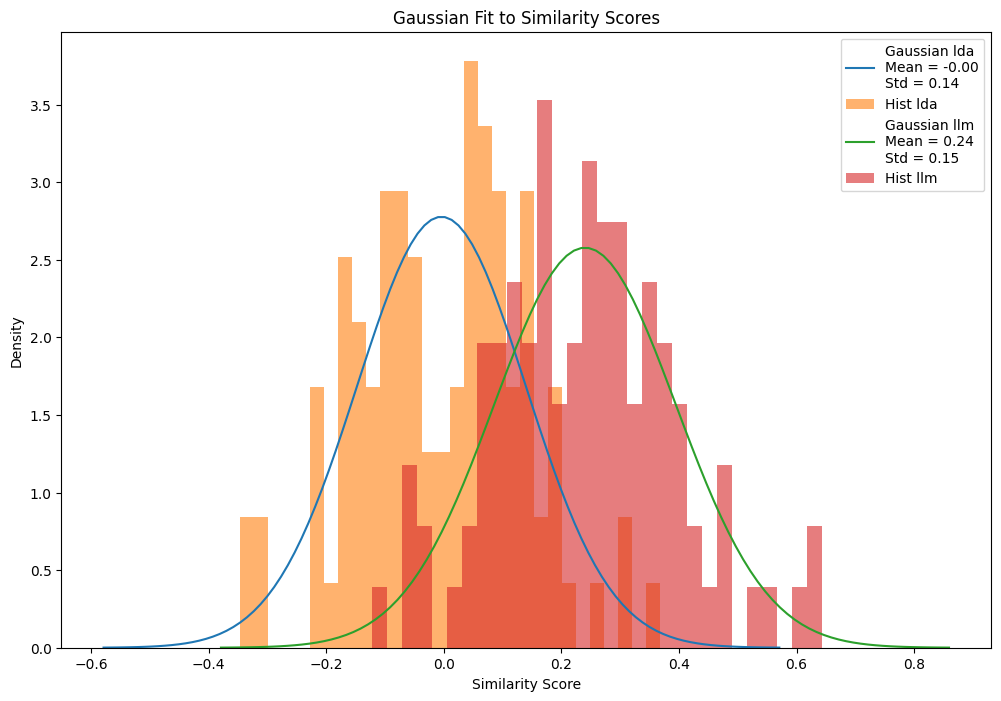

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def plot_gaussian(df, similarity_columns):
    """
    Plot the similarity scores as a Gaussian distribution.
    
    Parameters:
    df (DataFrame): Input dataframe containing similarity scores.
    similarity_columns (str): Column name of the similarity scores.
    
    Returns:
    None: Plots the Gaussian distribution.
    """
    fig, ax = plt.subplots(figsize=(12, 8))
    
    for column in similarity_columns:
        # Calculate the mean and standard deviation
        mean_similarity = df[column].mean()
        std_similarity = df[column].std()
    
        # Generate x values (range of similarity scores)
        x = np.linspace(mean_similarity - 4*std_similarity, mean_similarity + 4*std_similarity, 100)
        # Generate y values using the Gaussian formula (normal distribution)
        y = norm.pdf(x, mean_similarity, std_similarity)
        method_name = column.split('_')[2]  
        # Plot the Gaussian curve
        ax.plot(x, y, label=f'Gaussian {method_name}\nMean = {mean_similarity:.2f}\nStd = {std_similarity:.2f}')
        # Plot histogram of actual similarity values
        ax.hist(df[column], bins=30, density=True, alpha=0.6, label=f'Hist {method_name}')

    # Add labels and title
    plt.title("Gaussian Fit to Similarity Scores")
    ax.set_xlabel('Similarity Score')
    ax.set_ylabel('Density')
    # Show legend
    ax.legend() 
    # Show plot
    plt.show()

# Example usage:
plot_gaussian(df=df_sample, similarity_columns=['cosine_similarity_lda', 'cosine_similarity_llm'])